In [1]:
import pandas as pd

df = pd.read_csv('Emotion_final.csv')
df.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [2]:
df['Emotion'].value_counts()

happy       7029
sadness     6265
anger       2993
fear        2652
love        1641
surprise     879
Name: Emotion, dtype: int64

In [3]:
# import packages for text processing
import nltk
# nltk.download('wordnet')
# nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re 

stopwords = stopwords.words('english')
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [31]:
word = 'running'

print("Stem: ", stemmer.stem(word))
print("Lemma: ", lemmatizer.lemmatize(word))


Stem:  run
Lemma:  running


In [4]:
# write preprocessing function that will be applied to text data
def process_text(text, technique):

    text = text.lower()    # Lower: convert all characters to lowercase, will be applied to all techniques
    
    if technique == "Lower":    # Lower: convert all characters to lowercase
        return text
    
    elif technique == "Lower+Punct":    
        text = re.sub(r'[^\w\s]', '', text)     # remove punctuation and non-ascii characters
        
    elif technique == "Lower+Punct+Stop":  
        text = re.sub(r'[^\w\s]', '', text)     # remove punctuation and non-ascii characters
        text = " ".join([word for word in text.split() if word not in stopwords])   # remove stopwords
        
    elif technique == "Lower+Punct+Stop+Stem":
        text = re.sub(r'[^\w\s]', '', text)    # remove punctuation and non-ascii characters
        text = " ".join([stemmer.stem(word) for word in text.split() if word not in stopwords])  # remove stopwords and stem
        
    elif technique == "Lower+Punct+Stop+Lemmatize":
        text = re.sub(r'[^\w\s]', '', text)     # remove punctuation and non-ascii characters
        text = " ".join([lemmatizer.lemmatize(word) for word in text.split() if word not in stopwords]) # remove stopwords and lemmatize
    
    return text

In [5]:
preprocessing_techniques = ["Lower", "Lower+Punct", "Lower+Punct+Stop", "Lower+Punct+Stop+Stem", "Lower+Punct+Stop+Lemmatize"]

sentence = "Hey! i am experiencing the effects of preprocessing."
print("Original sentence: ", sentence)
print() # empty line
for prep_tech in preprocessing_techniques:
    print(prep_tech, ":", process_text(sentence, prep_tech))

Original sentence:  Hey! i am experiencing the effects of preprocessing.

Lower : hey! i am experiencing the effects of preprocessing.
Lower+Punct : hey i am experiencing the effects of preprocessing
Lower+Punct+Stop : hey experiencing effects preprocessing
Lower+Punct+Stop+Stem : hey experienc effect preprocess
Lower+Punct+Stop+Lemmatize : hey experiencing effect preprocessing


In [6]:
# import packages for model training
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import fasttext
import numpy as np


In [4]:
# apply preprocessing function to text data
# use Lower+Punct technique
import pandas as pd
preprocessing_technique = "Lower+Punct+Stop"
df = pd.read_csv('Emotion_final.csv')
df['Text'] = df['Text'].apply(lambda x: process_text(x, preprocessing_technique))
df

,Text,Emotion
0,didnt feel humiliated,sadness
1,go feeling hopeless damned hopeful around some...,sadness
2,im grabbing minute post feel greedy wrong,anger
3,ever feeling nostalgic fireplace know still pr...,love
4,feeling grouchy,anger
...,...,...
21454,melissa stared friend dism,fear
21455,successive state elections seen governing part...,fear
21456,vincent irritated dismay,fear
21457,kendallhume turned back face dismayed coup,fear


In [7]:
# write a function for Naive Bayes

def cross_val_for_naive_bayes(preprocessed_df):
    """df: dataframe that contains text and category columns"""
    
    vectorizer = CountVectorizer(analyzer='word', max_features=10000)   # initialize vectorizer
    X = vectorizer.fit_transform(preprocessed_df['Text'])    # fit and transform text data
    
    X = X.toarray()    # convert sparse matrix to numpy array
    y = preprocessed_df['Emotion']    # get target values

    # initialize model
    model = MultinomialNB()
    
    scores = cross_val_score(model, X, y, cv=5, scoring='f1_macro')    # get cross validation scores
    return scores   # return scores

# scores = cross_val_for_naive_bayes(df)
# print(preprocessing_technique)
# print(scores)
# print("Mean score: ", np.mean(scores))
    

In [8]:
def cross_val_for_fasttext(preprocessed_df):
    """split dataset into 5 folds and train fasttext model on each fold"""
    
    preprocessed_df['Emotion'] = '__label__' + preprocessed_df['Emotion'].astype(str)    # add label prefix to target values

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)    # initialize kfold
    scores = []    # initialize list for storing scores
    for train_index, test_index in kfold.split(preprocessed_df['Text'], preprocessed_df['Emotion']):
        train_df = preprocessed_df.iloc[train_index]    # get train data
        test_df = preprocessed_df.iloc[test_index]    # get test data
        
        # write train and test data to txt files
        train_df[['Emotion', 'Text']].to_csv('train.txt', sep='\t', index=False, header=False)
        test_df[['Emotion', 'Text']].to_csv('test.txt', sep='\t', index=False, header=False)

        # train fasttext model
        model = fasttext.train_supervised(input='train.txt')
        N, precision, recall = model.test('test.txt')    # get test results
        F1 = 2 * (precision * recall) / (precision + recall)
        scores.append(F1)    # append F1 score to scores list
    
    return scores    # return mean f1 score
        
# scores = cross_val_for_fasttext(df) 
# print(preprocessing_technique)
# print(scores)
# print("Mean Score: ", sum(scores)/len(scores))

In [9]:
# write main function which will run all preprocessing techniques and models

# initialize lists for storing scores
naive_bayes_scores = []
svm_scores = []
fasttext_scores = []

# iterate over each preprocessing technique
for technique in preprocessing_techniques:
    print("Running for ", technique, " technique")
    df = pd.read_csv('Emotion_final.csv')   # read data from csv file
    df['Text'] = df['Text'].apply(lambda x: process_text(x, technique))    # preprocess text data
    
    # get scores for each model
    naive_bayes_cross_val_scores = cross_val_for_naive_bayes(df)
    naive_bayes_scores.append(np.mean(naive_bayes_cross_val_scores))
    print("Naive Bayes: ", naive_bayes_cross_val_scores)
    
    
    fasttext_cross_val_scores = cross_val_for_fasttext(df)
    fasttext_scores.append(sum(fasttext_cross_val_scores)/len(fasttext_cross_val_scores))
    print("Fasttext: ", fasttext_cross_val_scores)

# plot scores for each model
print(naive_bayes_scores)
print(fasttext_scores)

Running for  Lower  technique
Naive Bayes:  [0.66061798 0.64907909 0.65701512 0.66514546 0.55232819]
Fasttext:  [0.8143056849953403, 0.804054054054054, 0.8224603914259087, 0.8026561043802423, 0.7995805173619203]
Running for  Lower+Punct  technique
Naive Bayes:  [0.65932982 0.64570134 0.65555685 0.66696091 0.55643898]
Fasttext:  [0.8024231127679403, 0.809878844361603, 0.8194315004659832, 0.8082479030754893, 0.7918900023304591]
Running for  Lower+Punct+Stop  technique
Naive Bayes:  [0.69290513 0.68123422 0.69442958 0.70765521 0.58466874]
Fasttext:  [0.8788443616029823, 0.8772134203168686, 0.8772134203168686, 0.880708294501398, 0.8769517594966209]
Running for  Lower+Punct+Stop+Stem  technique
Naive Bayes:  [0.63509757 0.61722161 0.62770672 0.64075915 0.5583999 ]
Fasttext:  [0.8518173345759553, 0.8508853681267474, 0.8443616029822927, 0.8485554520037278, 0.8492192962013515]
Running for  Lower+Punct+Stop+Lemmatize  technique
Naive Bayes:  [0.68768962 0.68485497 0.69896011 0.70120572 0.579590

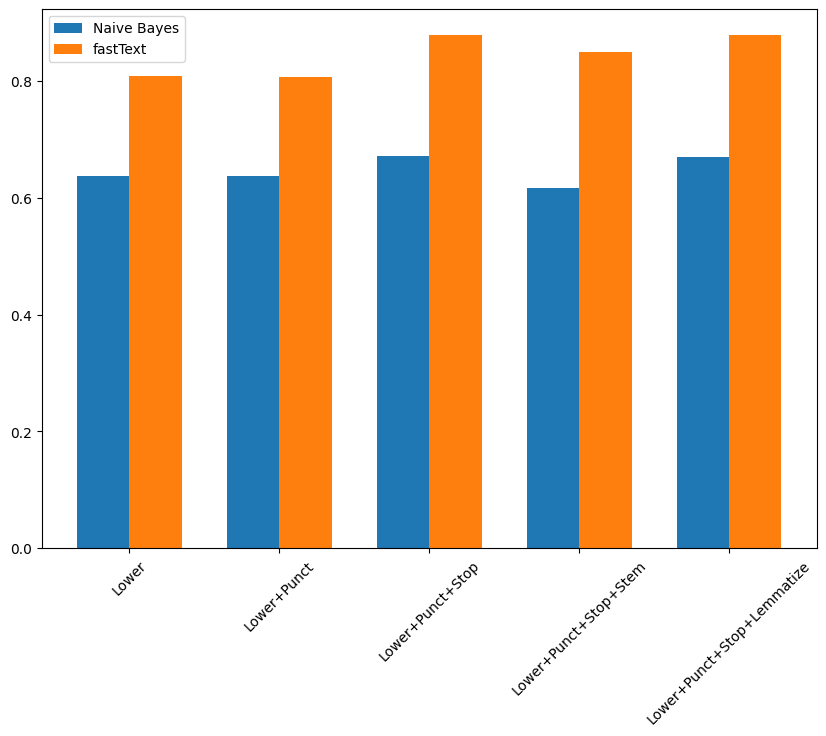

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Set the width of each bar
bar_width = 0.35

# Set the x positions of the bars
bar_positions_model1 = np.arange(len(preprocessing_techniques))
bar_positions_model2 = bar_positions_model1 + bar_width

plt.figure(figsize=(10,7))

# Plotting the scores for Model 1
plt.bar(bar_positions_model1, naive_bayes_scores, width=bar_width, label='Naive Bayes')

# Plotting the scores for Model 2
plt.bar(bar_positions_model2, fasttext_scores, width=bar_width, label='fastText')

# Adding x-axis tick labels
plt.xticks(bar_positions_model1 + bar_width/2, preprocessing_techniques, rotation=45)
# plt.xticks(rotation=45)
# Adding a legend
plt.legend()

# Displaying the plot
plt.show()

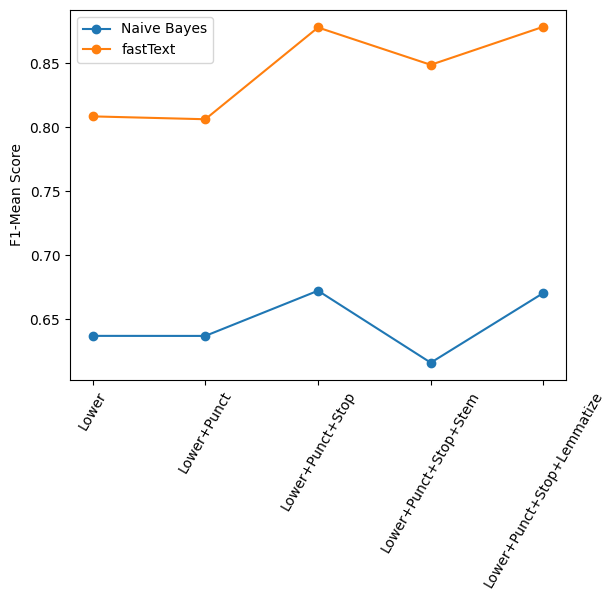

In [47]:
plt.plot(preprocessing_techniques, naive_bayes_scores, marker='o', label='Naive Bayes')
plt.plot(preprocessing_techniques, fasttext_scores, marker='o', label='fastText')
# plt.xlabel("Preprocessing Technique")
plt.ylabel("F1-Mean Score")
plt.xticks(rotation=60)
plt.legend()
plt.show()